In [23]:
import pandas as pd
import harboropt_lp_storage_buildyear_projectedcosts_valueadditionalenergy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tnrange
import seaborn as sns
%reload_ext autoreload
%autoreload 2

#### In the cell below, you can change the following input parameters:


initial_state_of_charge = state of charge of all storage resources at first time step

timespan = lifespan of portfolio in years (future variable costs are discounted based on this value)

gas_fuel_cost = cost of fuel for natural gas plants ($/mmbtu)

discount_rate = annual rate of decay of the value of money

build_years = number of years over which portfolio of resources is built

transmission_cost_per_mw = cost of transmission capacity for out of basin resources ($/MW)

storage_resilience_incentive_per_kwh = incentive per kwh of resilient storage capacity ($/kwh)

resilient_storage_grid_fraction = fraction of resilient storage capacity that can be used by grid (vs. reserved for host)

carbon_cost_per_ton = cost of emitting one metric ton of CO2 ($/tonne)

pm25_cost_per_ton = cost of emitting one metric ton of PM2.5 ($/tonne)

nox_cost_per_ton_LA = cost of emitting one metric ton of NOx in LA ($/tonne) 

so2_cost_per_ton_LA = cost of emitting one metric ton of SO2 in LA ($/tonne)

pm10_cost_per_ton = cost of emitting one metric ton of PM10 ($/tonne)


#### After running the cells below, wait for this message before running any subsequent cells: 'Solver found optimal solution.'


In [24]:
lp = harboropt_lp_storage_buildyear_projectedcosts_valueadditionalenergy.LinearProgram(build_years = 10, build_start_year = 2020,
                    storage_can_charge_from_grid = False, ee_cost_type = 'utility_side')
lp.solve()

ValueError: cannot convert float NaN to integer

In [37]:
lcoes = lp.get_lcoe_per_mwh()

gas_ct : Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.
gas_ct : Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.
gas_ct : Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.
gas_ct : Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.
gas_ct : Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.
gas_ct : Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.
gas_ct : Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.
gas_ct : Resource is not selected in optimization solution. Cannot calculate LCOE because annual generation is N/A.
gas_ct : Resource is not selected in optimization solution. Cannot calcu

In [39]:
lcoes.rename(columns={0: 2020, 1: 2021, 2:2022, 3: 2023, 4:2024, 5:2025, 6:2026, 7:2027, 8:2028, 9:2029}, inplace=True)

In [41]:
lcoes = lcoes[lcoes['lceo_type']=='no_cobenefits']

In [48]:
lcoes.to_csv('data/lcoe_outputs_12_7_21.csv')

In [5]:
resources = pd.read_csv('data/resources.csv')
nondisp_resources = resources.loc[resources['dispatchable'] == 'n']['resource']

In [6]:
runs = {}

for resource in nondisp_resources:
    print(resource)
    lp = harboropt_lp_storage_buildyear_projectedcosts_valueadditionalenergy.LinearProgram(build_years = 1, build_start_year = 2018,
                    storage_can_charge_from_grid = False)
    lp.solve()
    runs[resource] = lp 

utility_solar_outofbasin


KeyboardInterrupt: 

In [ ]:
capacity_upper_limits = {}
for key in runs:
    upper_limit_dict = runs[key].get_capacities_mw(0)
    capacity_upper_limits.update(upper_limit_dict)


In [ ]:
upper_limit_df = pd.DataFrame(capacity_upper_limits.items(), columns=['resource', 'upper_limit_mw'])

In [28]:
capacity_fractions = lp.get_capacity_fractions(0)

In [74]:
#lcoe_dict = lp.get_lcoe_per_mwh()

In [29]:
gen = lp.get_generation_mwh(0)

In [3]:
capacities = lp.get_capacities_mw(0)

#### Select a build year, start hour, and end hour to display results. Note: index starts at 0 (0 means build year 1 and hour 1).

In [59]:
#Choose a build year to display results, index starts at 0.
results_year = 0

#Choose the hour range to display results, index starts at 0.
start_hour = 0
end_hour = 100

#### Run the following 2 cells without changing any values.

In [60]:
results_hour_start = 8760*results_year
results_hour_end = 8760*results_year + 8760
resource_gen_dict = {}
resource_charge_dict = {}

for resource in lp.disp.index:
    gen_list = []
    for i_gen in lp.disp_gen[str(resource)][results_hour_start:results_hour_end]:
        gen = i_gen.solution_value()
        gen_list.append(gen)
    if any(gen_list):
        resource_gen_dict[resource]=gen_list

for resource in lp.nondisp.index:
    profiles = pd.read_csv('data/gen_profiles.csv')
    profile_max = max(profiles[resource])
    profile = profiles[resource] / profile_max
    
    capacity = lp.capacity_vars[resource][results_year].solution_value()
    
    gen_list = profile * capacity
    if any(gen_list):
        resource_gen_dict[resource]=gen_list
    
for resource in lp.storage.index:
    storage_hourly_charge = []
    for i,var in enumerate(lp.storage_charge_vars[resource]):
        charge = var.solution_value()
        storage_hourly_charge.append(-charge)
        
    storage_hourly_charge = storage_hourly_charge[results_hour_start:results_hour_end]
    
    if any(storage_hourly_charge):
        resource_charge_dict[resource + '_CHARGE'] = storage_hourly_charge
    
for resource in lp.storage.index:
    storage_hourly_discharge = []
    for i,var in enumerate(lp.storage_discharge_vars[resource]):
        discharge = var.solution_value() * .85
        storage_hourly_discharge.append(discharge)
        
    storage_hourly_discharge = storage_hourly_discharge[results_hour_start:results_hour_end]
    if any(storage_hourly_discharge):
        resource_gen_dict[resource + '_DISCHARGE']=storage_hourly_discharge
    
all_gen_resources = list(resource_gen_dict.keys())
all_charge_resources = list(resource_charge_dict.keys())

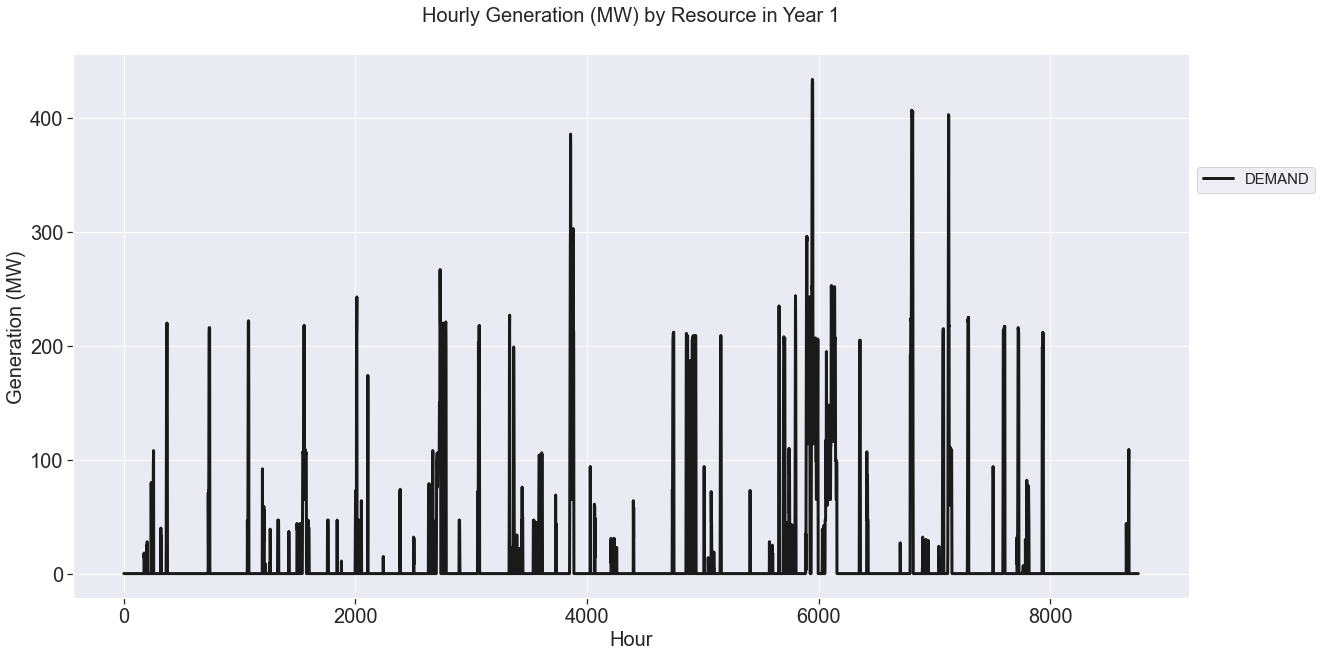

In [72]:
fig, ax = plt.subplots()

#Plot generation lines for each resource as stacked area chart.
lst = list(resource_gen_dict.values())
lines = [item[start_hour:end_hour] for item in lst]
labels = list(resource_gen_dict.keys())

if resource_charge_dict.keys():
    lst_neg = list(resource_charge_dict.values())
    lines_neg = [item[start_hour:end_hour] for item in lst_neg]
    labels_neg = list(resource_charge_dict.keys())

cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1.0, (len(lines))))
if resource_charge_dict.keys():
    colors = cmap(np.linspace(0, 1.0, (len(lines)+len(lines_neg))))

plt.stackplot(profiles.index[start_hour:end_hour], lines, labels = labels, colors = colors[0:len(lines)+1])

if resource_charge_dict.keys():
    plt.stackplot(profiles.index[start_hour:end_hour], lines_neg, labels = labels_neg, colors = colors[len(lines):])

#Plot demand.
harbor = pd.read_csv('data/harbor_hourly_gen_emissions_2019.csv')
harbor = harbor.fillna(0)
plt.plot(profiles.index[start_hour:end_hour], harbor['load_mw'][start_hour:end_hour], label = 'DEMAND', color = 'k', linewidth = 3)


sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77), fontsize = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Hour', fontsize = 20)
ax.set_ylabel('Generation (MW)', fontsize = 20)
ax.set_title('Hourly Generation (MW) by Resource in Year '+ str(results_year+1),fontsize = 20).set_position([.5, 1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.set_size_inches(20, 10)

#### To plot by individual resource, run the following cell to get a list of resource names. Then choose one and put it in quotations in the subsequent cell.

In [62]:
print(list(resource_gen_dict.keys()))

['FCZ7.Commercial.College.Cooking']


In [69]:
#Change resource name in quotations 
selected_resource = 'FCZ7.Commercial.College.Cooking'

#### Choose a build year, start hour, and end hour to display results.

In [70]:
#Choose a build year to display results, index starts at 0.
results_year = 0

#Choose the hour range to display results, index starts at 0.
start_hour = 0
end_hour = 8760

AttributeError: 'DataFrame' object has no attribute 'DEMAND'

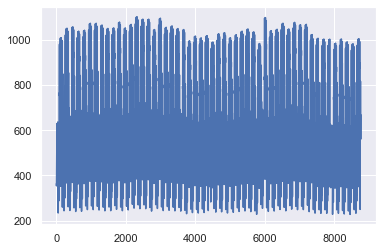

In [71]:
fig, ax = plt.subplots()

if selected_resource in list(resource_gen_dict.keys()):
    gen_line = resource_gen_dict[selected_resource]
    plt.plot(profiles.index[start_hour:end_hour], gen_line[start_hour:end_hour], label = str(selected_resource)) 

if selected_resource in list(resource_charge_dict.keys()):
    gen_line = resource_charge_dict[selected_resource]
    plt.plot(profiles.index[start_hour:end_hour], gen_line[start_hour:end_hour], label = str(selected_resource)) 
    
#Plot demand.
plt.plot(profiles.index[start_hour:end_hour], profiles.DEMAND[start_hour:end_hour], label = 'DEMAND', color = 'k')


sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Hour', fontsize = 20)
ax.set_ylabel('Generation (MW)', fontsize = 20)
ax.set_title(selected_resource +' Hourly Generation (MW) in Year '+ str(results_year+1),fontsize = 20).set_position([.5, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig.set_size_inches(14, 8)

#### To sweep through values of a particular parameter, follow the format below. Set the chosen parameter equal to the 'parameter_value' when running the linear program. Then run the cell and wait for the solver to find the optimal solution for each parameter value.

In [28]:
runs = {}

#Change the values in parentheses to starting value, ending value, interval between runs.
for parameter_value in np.arange(0, 1500, 500):
    print(parameter_value)
    
    #Set the chosen parameter equal to 'parameter_value'
    lp = harboropt_lp_storage_buildyear_emissions.LinearProgram(storage_resilience_incentive_per_kwh = parameter_value)
    lp.solve()
    runs[parameter_value] = lp 

0
Solver found optimal solution.
500
Solver found optimal solution.
1000
Solver found optimal solution.


#### Follow the format below to plot the results. In the following example, resilient storage capacity is plotted as a function of the resilient storage incentive.

In [29]:
#Create list of the parameter values looped through above. This will become the x-axis in the figure below.
parameter_values = []

#Create list to hold output values for the dependent variable. This will beomce the y-axis in the figure below.
y_values = []

#Loop through the optimization results, adding the x-values and y-values to the lists above.
for key in runs:
    parameter_values.append(key)
    
    #In this case, the y-value is the storage capacity solution value in the chosen results year. For non-storage resource capacity solution values, use "runs[key].capacity_vars" instead of "runs[key].storage_capacity_vars"
    y_value = runs[key].storage_capacity_vars['resilient_standalone_storage_4hr'][results_year].solution_value()
    y_values.append(y_value)

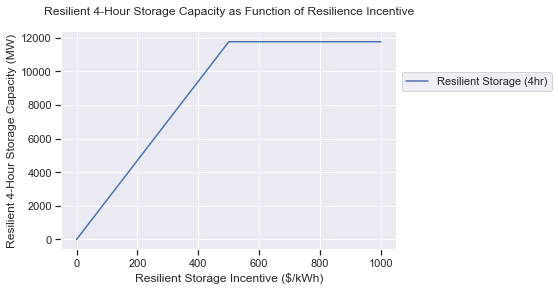

In [30]:
#Change labels to reflect variables graphed.

fig, ax = plt.subplots()

plt.plot(parameter_values, y_values, label = 'Resilient Storage (4hr)') 

sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Resilient Storage Incentive ($/kWh)')
ax.set_ylabel('Resilient 4-Hour Storage Capacity (MW)')
ax.set_title('Resilient 4-Hour Storage Capacity as Function of Resilience Incentive').set_position([.5, 1.05])